# Model Assessment

In [1]:
from tqdm.notebook import tqdm
import pickle, gzip
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

import nibabel as nib
from nilearn import maskers
from nilearn import plotting, datasets, image
from nilearn.plotting.displays import MosaicSlicer
from nilearn.image import resample_img
from nilearn.plotting import plot_stat_map, view_img


from neurovlm.data import data_dir
from neurovlm.data import get_data_dir
from neurovlm.models import Specter
from neurovlm.retrieval_resources import _load_autoencoder

from neurovlm.brain_input import search_papers_from_brain, search_wiki_from_brain, resample_array_nifti, _load_mask_bundle, search_cogatlas_from_brain

In [2]:
with gzip.open(get_data_dir() / f"networks_arrays.pkl.gz", "rb") as f:
    networks = pickle.load(f)

proj_head_mse_adhoc = torch.load(get_data_dir() / f"proj_head_image_infonce.pt", weights_only=False).cpu()
proj_head_img = torch.load(get_data_dir() / f"proj_head_image_infonce.pt", weights_only=False).cpu()
proj_head_text = torch.load(get_data_dir() / f"proj_head_text_infonce.pt", weights_only=False).cpu()
specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query")
autoencoder = torch.load(get_data_dir() / "autoencoder_sparse.pt", weights_only=False).cpu()
# decoder = autoencoder.decoder.to("cpu")
mask_arrays = np.load(f"{get_data_dir()}/mask.npz", allow_pickle=True)
mask_img = nib.Nifti1Image(mask_arrays["mask"].astype(float),  mask_arrays["affine"])
masker = maskers.NiftiMasker(mask_img=mask_img, dtype=np.float32).fit()

There are adapters available but none are activated for the forward pass.


## Network vs. articles

In [3]:
networks = {k: v for _k in networks.keys() for k, v in networks[_k].items()}

In [30]:
mask_arrays = np.load(f"{get_data_dir()}/mask.npz", allow_pickle=True)
mask_img = nib.Nifti1Image(mask_arrays["mask"].astype(float),  mask_arrays["affine"])
masker = maskers.NiftiMasker(mask_img=mask_img, dtype=np.float32).fit()
networks_resampled = {}

for k in tqdm(networks.keys(), total=len(networks)):
    img = nib.Nifti1Image(networks[k]["array"], affine=networks[k]["affine"])

    if len(np.unique(networks[k]["array"])) == 2:
        # binary data
        img_resampled = resample_img(img, mask_arrays["affine"], interpolation="nearest")
    else:
        img_resampled = resample_img(img, mask_arrays["affine"])
        img_resampled_arr = img_resampled.get_fdata()
        img_resampled_arr[img_resampled_arr < 0] = 0.
        thresh = np.percentile(img_resampled_arr.flatten(), 99)
        img_resampled_arr[img_resampled_arr < thresh] = 0.
        img_resampled_arr[img_resampled_arr >= thresh] = 1.
        img_resampled = nib.Nifti1Image(img_resampled_arr, affine=mask_arrays["affine"])

    networks_resampled[k] = img_resampled

  0%|          | 0/152 [00:00<?, ?it/s]

In [31]:
networks_embed = {}

for k, v in tqdm(networks_resampled.items(), total=len(networks_resampled)):
    networks_embed[k] = autoencoder.encoder(torch.from_numpy(masker.transform(v)))

  0%|          | 0/152 [00:00<?, ?it/s]

In [6]:
brain_network_abbrev = {
    # Primary abbreviations with clear expansions
    'VIS-P': 'Visual - Primary/Peripheral',
    'DN-B': 'Default Network - B',
    'SMOT-B': 'Sensorimotor - B',
    'AUD': 'Auditory',
    'dATN-B': 'Dorsal Attention Network - B',
    'SMOT-A': 'Sensorimotor - A',
    'LANG': 'Language',
    'FPN-B': 'Frontoparietal Network - B',
    'FPN-A': 'Frontoparietal Network - A',
    'dATN-A': 'Dorsal Attention Network - A',
    'VIS-C': 'Visual - Central/Core',
    'SAL/PMN': 'Salience/Posterior Multimodal Network',
    'DN-A': 'Default Network - A',
    'Visual1': 'Visual Network 1',
    'Visual2': 'Visual Network 2',
    'Visual3': 'Visual Network 3',
    'Somatomotor': 'Somatomotor',
    'CingOperc': 'Cingulo-Opercular',
    'DorsAttn': 'Dorsal Attention',
    'Language': 'Language',
    'FrontPar': 'Frontoparietal',
    'Auditory': 'Auditory',
    'Default': 'Default Mode Network',
    'PostMulti': 'Posterior Multimodal',
    'VentMulti': 'Ventral Multimodal',
    'OrbitAffective': 'Orbitofrontal Affective',

    # Functional categories
    'Emo/Interoception1': 'Emotion/Interoception Network 1',
    'Emo/Interoception2': 'Emotion/Interoception Network 2',
    'Emo/Interoception3': 'Emotion/Interoception Network 3',
    'Emo/Interoception4': 'Emotion/Interoception Network 4',
    'Mot/Visspatial1': 'Motor/Visuospatial Network 1',
    'Mot/Visspatial2': 'Motor/Visuospatial Network 2',
    'Mot/Visspatial3': 'Motor/Visuospatial Network 3',
    'Mot/Visspatial4': 'Motor/Visuospatial Network 4',
    'DivergentCog1': 'Divergent Cognitive Network 1',
    'DivergentCog3': 'Divergent Cognitive Network 3',
    'DivergentCog4': 'Divergent Cognitive Network 4',
    'DivergentCog5': 'Divergent Cognitive Network 5',
    'DivergentCog6': 'Divergent Cognitive Network 6',

    # Descriptive names
    'medial frontal': 'Medial Frontal',
    'frontoparietal': 'Frontoparietal',
    'default mode': 'Default Mode Network',
    'motor cortex': 'Motor Cortex',
    'visual A': 'Visual Network A',
    'visual B': 'Visual Network B',
    'visual association': 'Visual Association',
    'subcortical cerebellum': 'Subcortical Cerebellum',

    # More specific networks
    'AntSal': 'Anterior Salience',
    'DorsalDMN': 'Dorsal Default Mode Network',
    'HighVisual': 'Higher-Order Visual',
    'LECN': 'Left Executive Control Network',
    'PostSal': 'Posterior Salience',
    'Precuneus': 'Precuneus Network',
    'PrimVisual': 'Primary Visual',
    'RECN': 'Right Executive Control Network',
    'Sensorimotor': 'Sensorimotor',
    'VentralDMN': 'Ventral Default Mode Network',
    'Visuospatial': 'Visuospatial',
    'LatVis': 'Lateral Visual',
    'MedVis': 'Medial Visual',
    'Premotor': 'Premotor',
    'Salience': 'Salience',

    # Effector-specific
    'HandSM': 'Hand Sensorimotor',
    'FaceSM': 'Face Sensorimotor',
    'FootSM': 'Foot Sensorimotor',
    'Effector-hand': 'Hand Effector',
    'Effector-mouth': 'Mouth Effector',
    'Effector-foot': 'Foot Effector',

    # Memory systems
    'AntMTL': 'Anterior Medial Temporal Lobe',
    'PostMTL': 'Posterior Medial Temporal Lobe',
    'ParMemory': 'Parietal Memory',
    'Context': 'Context Network',

    # Other networks
    'Visual': 'Visual',
    'VentAttn': 'Ventral Attention',
    'DorsalSM': 'Dorsal Sensorimotor',
    'VentralSM': 'Ventral Sensorimotor',
    'MedPar': 'Medial Parietal',
    'ParOcc': 'Parietal-Occipital',
    'Cingulo-Opercular': 'Cingulo-Opercular',
    'SM': 'Sensorimotor',
    'LateralSM': 'Lateral Sensorimotor',

    # Task-related
    'ResponseOneHanded(1RESP)': 'Response One-Handed',
    'ResponseTwoHanded(2RESP)': 'Response Two-Handed',
    'AuditoryAttentionResponse(AAR)': 'Auditory Attention Response',
    'AuditoryPrimarySensory(AUD)': 'Auditory Primary Sensory',
    'DMNNovel(DMNA)': 'Default Mode Network - Novel',
    'DMNTraditional(DMNB)': 'Default Mode Network - Traditional',
    'FocusOnVisualFeatures(FoVF)': 'Focus on Visual Features',
    'Initiation(INIT)': 'Initiation',
    'Language(LN)': 'Language',
    'MultipleDemand(MDN)': 'Multiple Demand Network',
    'Re-evaluation(RE-EV)': 'Re-evaluation',

    # Yeo-style subdivisions
    'DefaultA': 'Default Mode Network A',
    'DefaultB': 'Default Mode Network B',
    'DefaultC': 'Default Mode Network C',
    'ControlA': 'Control Network A',
    'ControlB': 'Control Network B',
    'ControlC': 'Control Network C',
    'Control': 'Control Network',
    'SalVenAttnA': 'Salience/Ventral Attention A',
    'SalVenAttnB': 'Salience/Ventral Attention B',
    'SalVentAttnA': 'Salience/Ventral Attention A',
    'SalVentAttnB': 'Salience/Ventral Attention B',
    'Sal/VenAttnA': 'Salience/Ventral Attention A',
    'Sal/VenAttnB': 'Salience/Ventral Attention B',
    'Sal/VenAttn': 'Salience/Ventral Attention',
    'DorsAttnA': 'Dorsal Attention A',
    'DorsAttnB': 'Dorsal Attention B',
    'Aud': 'Auditory',
    'SomMotA': 'Somatomotor A',
    'SomMotB': 'Somatomotor B',
    'SomatomotorA': 'Somatomotor A',
    'SomatomotorB': 'Somatomotor B',
    'VisualA': 'Visual A',
    'VisualB': 'Visual B',
    'VisualC': 'Visual C',
    'VisPeri': 'Visual Peripheral',
    'VisCent': 'Visual Central',
    'TempPar': 'Temporal-Parietal',
    'LimbicA': 'Limbic A',
    'LimbicB': 'Limbic B',
    'Limbic': 'Limbic',
}

In [56]:
abstract, titles, similarity_score = search_papers_from_brain(networks_embed["Visual1"], show_titles=True)

Top matches:
1. Brain Areas Active during Visual Perception of Biological Motion.
2. Specificity of regions processing biological motion.
3. Creating Concepts from Converging Features in Human Cortex
4. The extraction of 3D shape from texture and shading in the human brain.
5. Neural representation of animacy in the early visual areas: A functional MRI study


In [8]:
similarity_score

array([0.49415398, 0.47872347, 0.47638857, 0.47117653, 0.46807933],
      dtype=float32)

In [53]:
wiki_title, wiki_summary, wiki_similarity_score = search_wiki_from_brain(networks_embed["Visual1"], show_titles=True)

Top matches:
1. Visual literacy
2. Eye movement in scene viewing


In [10]:
wiki_similarity_score

array([0.42092273, 0.394619  ], dtype=float32)

In [52]:
cogatlas_title, cogatlas_description, cogatlas_similarity_score = search_cogatlas_from_brain(networks_embed["Visual1"], show_titles=True)

Top matches:
1. object perception
2. visual form discrimination
3. visual letter recognition
4. visual form recognition
5. visual word recognition


In [50]:
cogatlas_title

'[1] loss\nA state of deprivation of a motivationally significant con-specific, object, or situation. loss may be social or non-social and may include permanent or sustained loss of monetary values, shelter, behavioral control, status, loved ones, or relationships. the response to loss may be episodic (e.g., grief) or sustained.\n\n[2] cognitive heuristic\nAre simple, efficient rules, hard-coded by evolutionary processes or learned, which have been proposed to explain how people make decisions, come to judgments, and solve problems, typically when facing complex problems or incomplete information. these rules work well under most circumstances, but in certain cases lead to systematic errors or cognitive biases.\n\n[3] schema\nA structured representation that includes a particular organized way of perceiving and responding to a complex situation or set of stimuli.\n\n[4] working memory\nActive maintenance and flexible updating of goal/task relevant information (items, goals, strategies,

In [12]:
cogatlas_similarity_score

array([0.29497838, 0.29138774, 0.29109022, 0.2898947 , 0.2837941 ],
      dtype=float32)

# Ploting the Brain map

Network: DefaultA
Data range: 0.0 to 1.0
Unique values: [0. 1.]
Non-zero voxels: 1412


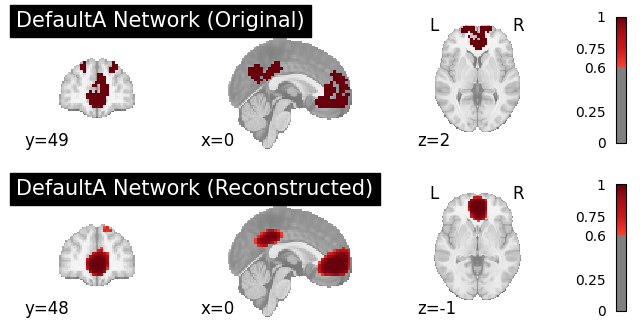

In [42]:
# Select the network to visualize
network_name = "DefaultA"
network_img = networks_resampled[network_name]

# Check the data range to understand what we're plotting
network_data = network_img.get_fdata()
print(f"Network: {network_name}")
print(f"Data range: {network_data.min()} to {network_data.max()}")
print(f"Unique values: {np.unique(network_data)}")
print(f"Non-zero voxels: {np.sum(network_data > 0)}")

# Predicted image
autoencoder = _load_autoencoder()
mask_arrays, _, masker = _load_mask_bundle(data_dir=data_dir)

# Transform network image to 1D vector and add batch dimension
network_transformed = torch.from_numpy(masker.transform(network_img)).unsqueeze(0)

# Pass through autoencoder and remove batch dimension
reconstruction = autoencoder(network_transformed)
# Handle both tuple and tensor returns
if isinstance(reconstruction, tuple):
    reconstruction = reconstruction[0]
img_pred = masker.inverse_transform(
    torch.sigmoid(reconstruction).squeeze(0).detach().numpy()
)

# Create brain map visualization
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))

# Plot the original network brain map
plot_stat_map(network_img,
              cmap="Reds",
              vmin=0, vmax=1,
              threshold=0.6,
              draw_cross=False,
              axes=axes[0],
              title=f'{network_name} Network (Original)');

# Plot the predicted/reconstructed network
plot_stat_map(img_pred,
              cmap="Reds",
              vmin=0, vmax=1,
              threshold=0.6,
              draw_cross=False,
              axes=axes[1],
              title=f'{network_name} Network (Reconstructed)');

In [29]:
network_transformed.unique()

tensor([0., 1.])

In [25]:
network_img

# How similar are the top K similar words from the network label

In [ ]:
# Load data sources
from neurovlm.retrieval_resources import _load_dataframe, _load_neuro_wiki, _load_cogatlas_dataset

# Load dataframes
df_papers = _load_dataframe()
df_wiki = _load_neuro_wiki()
df_cogatlas = _load_cogatlas_dataset()

print(f"Papers: {len(df_papers)} entries")
print(f"Wiki: {len(df_wiki)} entries")
print(f"CogAtlas: {len(df_cogatlas)} entries")

## Encoding text sources and computing similarities with network names

This section encodes different text sources (papers, wiki, cogatlas) using SPECTER and computes cosine similarity with network full names.

In [ ]:
# Function to encode and compute similarities
def compute_text_network_similarity(network_name, top_k_papers=5, top_k_wiki=2, top_k_cogatlas=5):
    """
    Compute cosine similarity between network name and different text sources.
    
    Parameters:
    -----------
    network_name : str
        Name of the network from networks_embed
    top_k_papers : int
        Number of top papers to retrieve
    top_k_wiki : int
        Number of top wiki entries to retrieve
    top_k_cogatlas : int
        Number of top cogatlas entries to retrieve
    
    Returns:
    --------
    dict : Dictionary with similarity scores for each text source
    """
    
    # Get network embedding
    if network_name not in networks_embed:
        print(f"Network {network_name} not found in networks_embed")
        return None
    
    network_embed = networks_embed[network_name]
    
    # Get network full name
    network_full_name = brain_network_abbrev.get(network_name, network_name)
    
    # Encode network full name using SPECTER
    network_name_embed = specter(network_full_name)
    network_name_proj = proj_head_text(network_name_embed)
    network_name_proj = network_name_proj / network_name_proj.norm()
    
    results = {
        'network_name': network_name,
        'network_full_name': network_full_name,
        'papers': [],
        'wiki': [],
        'cogatlas': []
    }
    
    # 1. Get top papers and compute similarities
    abstract, titles, _ = search_papers_from_brain(network_embed, top_k=top_k_papers, show_titles=False)
    
    # Find corresponding rows in dataframe
    title_col = "name" if "name" in df_papers.columns else "title"
    for title in titles:
        matching_rows = df_papers[df_papers[title_col].astype(str) == title]
        if len(matching_rows) > 0:
            row = matching_rows.iloc[0]
            # Create title + abstract pair
            paper_title = str(row.get(title_col, ''))
            paper_abstract = str(row.get('description', ''))
            
            # Encode using SPECTER
            paper_embed = specter({'title': paper_title, 'abstract': paper_abstract})
            paper_proj = proj_head_text(paper_embed)
            paper_proj = paper_proj / paper_proj.norm()
            
            # Compute cosine similarity
            similarity = (network_name_proj @ paper_proj.T).item()
            
            results['papers'].append({
                'title': paper_title,
                'similarity': similarity
            })
    
    # 2. Get top wiki entries and compute similarities
    wiki_context, wiki_titles, _ = search_wiki_from_brain(network_embed, top_k=top_k_wiki, show_titles=False)
    
    for wiki_title in wiki_titles:
        matching_rows = df_wiki[df_wiki['title'].astype(str) == wiki_title]
        if len(matching_rows) > 0:
            row = matching_rows.iloc[0]
            wiki_title_text = str(row.get('title', ''))
            wiki_summary_text = str(row.get('summary', ''))
            
            # Encode using SPECTER
            wiki_embed = specter({'title': wiki_title_text, 'summary': wiki_summary_text})
            wiki_proj = proj_head_text(wiki_embed)
            wiki_proj = wiki_proj / wiki_proj.norm()
            
            # Compute cosine similarity
            similarity = (network_name_proj @ wiki_proj.T).item()
            
            results['wiki'].append({
                'title': wiki_title_text,
                'similarity': similarity
            })
    
    # 3. Get top cogatlas entries and compute similarities
    cogatlas_context, cogatlas_terms, _ = search_cogatlas_from_brain(network_embed, top_k=top_k_cogatlas, show_titles=False)
    
    # Ensure term column is lowercase for matching
    df_cogatlas_lower = df_cogatlas.copy()
    df_cogatlas_lower['term'] = df_cogatlas_lower['term'].str.lower()
    
    for cogatlas_term in cogatlas_terms:
        matching_rows = df_cogatlas_lower[df_cogatlas_lower['term'] == cogatlas_term.lower()]
        if len(matching_rows) > 0:
            row = matching_rows.iloc[0]
            cogatlas_title_text = str(row.get('term', ''))
            cogatlas_description_text = str(row.get('definition', ''))
            
            # Encode using SPECTER
            cogatlas_embed = specter({'title': cogatlas_title_text, 'summary': cogatlas_description_text})
            cogatlas_proj = proj_head_text(cogatlas_embed)
            cogatlas_proj = cogatlas_proj / cogatlas_proj.norm()
            
            # Compute cosine similarity
            similarity = (network_name_proj @ cogatlas_proj.T).item()
            
            results['cogatlas'].append({
                'title': cogatlas_title_text,
                'similarity': similarity
            })
    
    return results

# Test with a single network first
test_results = compute_text_network_similarity("Visual1")
print(f"\nResults for {test_results['network_full_name']}:")
print(f"\nPapers ({len(test_results['papers'])} entries):")
for item in test_results['papers'][:3]:
    print(f"  {item['title'][:80]}... - Similarity: {item['similarity']:.4f}")

print(f"\nWiki ({len(test_results['wiki'])} entries):")
for item in test_results['wiki']:
    print(f"  {item['title']} - Similarity: {item['similarity']:.4f}")

print(f"\nCogAtlas ({len(test_results['cogatlas'])} entries):")
for item in test_results['cogatlas'][:3]:
    print(f"  {item['title']} - Similarity: {item['similarity']:.4f}")

In [ ]:
# Compute similarities for all networks that have entries in brain_network_abbrev
all_results = {}

# Get networks that are in both networks_embed and brain_network_abbrev
networks_to_process = [net for net in networks_embed.keys() if net in brain_network_abbrev]

print(f"Processing {len(networks_to_process)} networks...")

for network_name in tqdm(networks_to_process[:10]):  # Start with first 10 for testing
    results = compute_text_network_similarity(network_name)
    if results is not None:
        all_results[network_name] = results

print(f"\nProcessed {len(all_results)} networks")

## Results Tables

Below are the results organized in different table formats:

In [ ]:
# Create a combined table with all text sources
rows = []

for network_name, results in all_results.items():
    # Papers
    for i, paper in enumerate(results['papers'], 1):
        rows.append({
            'Network': network_name,
            'Network Full Name': results['network_full_name'],
            'Text Source': 'Papers',
            'Rank': i,
            'Text Title': paper['title'][:100],  # Truncate long titles
            'Similarity': paper['similarity']
        })
    
    # Wiki
    for i, wiki in enumerate(results['wiki'], 1):
        rows.append({
            'Network': network_name,
            'Network Full Name': results['network_full_name'],
            'Text Source': 'Wiki',
            'Rank': i,
            'Text Title': wiki['title'][:100],
            'Similarity': wiki['similarity']
        })
    
    # CogAtlas
    for i, cogatlas in enumerate(results['cogatlas'], 1):
        rows.append({
            'Network': network_name,
            'Network Full Name': results['network_full_name'],
            'Text Source': 'CogAtlas',
            'Rank': i,
            'Text Title': cogatlas['title'][:100],
            'Similarity': cogatlas['similarity']
        })

df_combined = pd.DataFrame(rows)

# Display summary statistics
print("Summary Statistics by Text Source:")
print(df_combined.groupby('Text Source')['Similarity'].describe())

# Show combined table
print("\nCombined Results (first 20 rows):")
df_combined.head(20)

In [ ]:
# Create separate tables for each text source

# Papers table
papers_rows = []
for network_name, results in all_results.items():
    for i, paper in enumerate(results['papers'], 1):
        papers_rows.append({
            'Network': network_name,
            'Network Full Name': results['network_full_name'],
            'Rank': i,
            'Paper Title': paper['title'][:150],
            'Similarity': paper['similarity']
        })
df_papers_results = pd.DataFrame(papers_rows)

# Wiki table
wiki_rows = []
for network_name, results in all_results.items():
    for i, wiki in enumerate(results['wiki'], 1):
        wiki_rows.append({
            'Network': network_name,
            'Network Full Name': results['network_full_name'],
            'Rank': i,
            'Wiki Title': wiki['title'],
            'Similarity': wiki['similarity']
        })
df_wiki_results = pd.DataFrame(wiki_rows)

# CogAtlas table
cogatlas_rows = []
for network_name, results in all_results.items():
    for i, cogatlas in enumerate(results['cogatlas'], 1):
        cogatlas_rows.append({
            'Network': network_name,
            'Network Full Name': results['network_full_name'],
            'Rank': i,
            'CogAtlas Term': cogatlas['title'],
            'Similarity': cogatlas['similarity']
        })
df_cogatlas_results = pd.DataFrame(cogatlas_rows)

print("Papers Results:")
print(df_papers_results.head(10))
print(f"\nTotal papers entries: {len(df_papers_results)}")

print("\n" + "="*80)
print("Wiki Results:")
print(df_wiki_results.head(10))
print(f"\nTotal wiki entries: {len(df_wiki_results)}")

print("\n" + "="*80)
print("CogAtlas Results:")
print(df_cogatlas_results.head(10))
print(f"\nTotal cogatlas entries: {len(df_cogatlas_results)}")

## Visualizations

Heatmaps and charts showing the similarity patterns across networks and text sources:

In [ ]:
# Visualize average similarities by network and text source
import seaborn as sns

# Calculate average similarity for each network and text source
avg_similarities = df_combined.groupby(['Network', 'Network Full Name', 'Text Source'])['Similarity'].mean().reset_index()

# Pivot for heatmap
pivot_data = avg_similarities.pivot(index='Network', columns='Text Source', values='Similarity')

# Create heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Average Cosine Similarity'})
plt.title('Average Cosine Similarity: Network Names vs Text Sources')
plt.xlabel('Text Source')
plt.ylabel('Network')
plt.tight_layout()
plt.show()

# Bar plot showing average similarity by text source
plt.figure(figsize=(10, 6))
avg_by_source = df_combined.groupby('Text Source')['Similarity'].mean().sort_values(ascending=False)
avg_by_source.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Average Cosine Similarity by Text Source')
plt.ylabel('Average Similarity')
plt.xlabel('Text Source')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Show top similarities for each network
print("Top Similarities per Network:")
print("="*100)

for network_name in sorted(all_results.keys()):
    results = all_results[network_name]
    print(f"\n{network_name} ({results['network_full_name']}):")
    
    # Get top paper
    if results['papers']:
        top_paper = max(results['papers'], key=lambda x: x['similarity'])
        print(f"  Best Paper: {top_paper['title'][:80]}... (sim: {top_paper['similarity']:.4f})")
    
    # Get top wiki
    if results['wiki']:
        top_wiki = max(results['wiki'], key=lambda x: x['similarity'])
        print(f"  Best Wiki: {top_wiki['title']} (sim: {top_wiki['similarity']:.4f})")
    
    # Get top cogatlas
    if results['cogatlas']:
        top_cogatlas = max(results['cogatlas'], key=lambda x: x['similarity'])
        print(f"  Best CogAtlas: {top_cogatlas['title']} (sim: {top_cogatlas['similarity']:.4f})")

## Optional: Process All Networks

Uncomment and run the cell below to process all networks (this may take some time):

In [ ]:
# # Uncomment to process ALL networks
# all_results_full = {}
# 
# for network_name in tqdm(networks_to_process):
#     results = compute_text_network_similarity(network_name)
#     if results is not None:
#         all_results_full[network_name] = results
# 
# print(f"\nProcessed {len(all_results_full)} networks")
# 
# # Update all_results to use the full results
# all_results = all_results_full